In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [2]:
from utils.dataloader import make_datapath_list, DataTransform


rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

In [3]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

state_dict = torch.load("./weights/pspnet50_30_reference.pth",
# state_dict = torch.load("./weights/pspnet50_30.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

<All keys matched successfully>

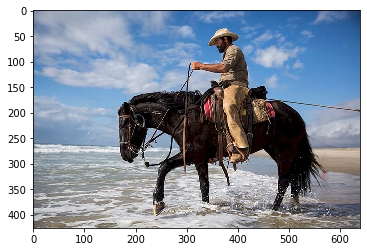

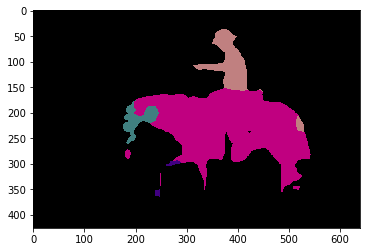

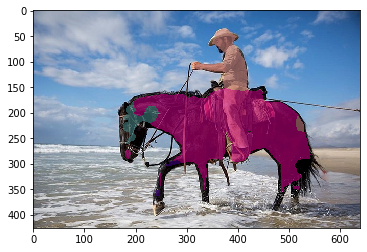

In [4]:
# 원본 화상 표시
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)   
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 전처리 클래스 작성
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 전처리, 적당한 어노테이션 이미지를 준비하여 색상 팔레트 정보 추출
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)

# PSPNet 으로 추론
net.eval()
x = img.unsqueeze(0)  
outputs = net(x)
y = outputs[0]  

# PSPNet 출력으로 최대 클래스를 구하여 색상 팔레트 형식으로 이미지 크기를 원래대로 되돌린다.
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 이미지를 투과시켜 겹친다.
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  

for x in range(img_width):
    for y in range(img_height):
        # 추론 결과 이미지의 픽셀 데이터를 취득
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            trans_img.putpixel((x, y), (r, g, b, 150))

img = Image.open(image_file_path)  
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()
